# Geometric Low-Rank Tensor Completion

- Nonconvex regularization: **TNN**: Truncated nuclear norm

----------------

Geometric Low-rank Tensor Completion (GLTC) is a machine learning model for reconstructing missing values within tensors. In particular, this model can use the graph regularizer (e.g., adjacent smoothness matrix based penalty in this study) to express side information.


### Truncated nuclear norm
Sort the singular values from large to small i.e. $\sigma_1 > \sigma_2 > \sigma_3 > ... > \sigma_n$. The proximal operator $P_{\alpha, \theta}(\sigma_i)$ is as follows:
$$
P_{\alpha, \theta}(\sigma_i) = \left\{
\begin{aligned}
\sigma_i &\quad, i <= \theta\\
[\sigma_i - \alpha]_+ &\quad, i > \theta
\end{aligned} \right.
$$

## Motivation: Real-World Applications

In the field of computer vision, tensor completion problem arises as as many pixels may be missing in color images.

### Graph in image

The nearby pixels are very similiar. Take the image of Lena as an example:

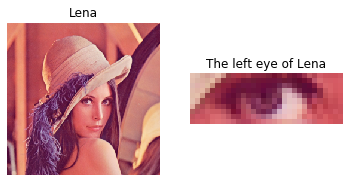

In [4]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('data/lena.bmp')

dim1, dim2, dim3 = lena.shape
a = int(dim1/2)
b = int(dim1/2) + 10
c = int(dim2/2) - 10
d = int(dim2/2) + 20

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena[a:b, c:d, :])
plt.title('The left eye of Lena')
plt.axis('off')

plt.show()

> Figure 1: Lena and her left eye.

## Selected Images

We carry out our image inpainting experiments on the images of `Lena` and `Peppers`.

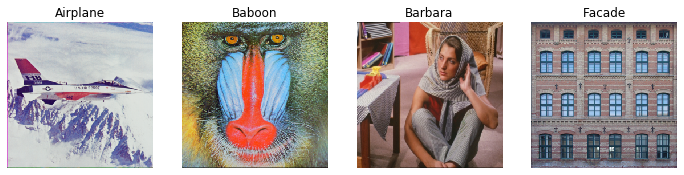

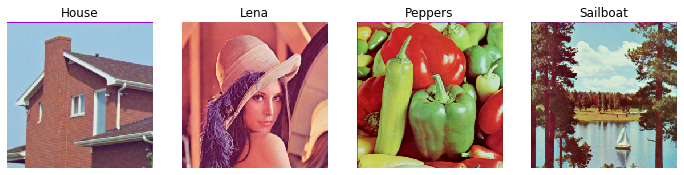

In [5]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/airplane.bmp'))
plt.title('Airplane')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/baboon.bmp'))
plt.title('Baboon')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/barbara.bmp'))
plt.title('Barbara')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/facade.bmp'))
plt.title('Facade')
plt.axis('off')

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/house.bmp'))
plt.title('House')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/lena.bmp'))
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/peppers.bmp'))
plt.title('Peppers')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/sailboat.bmp'))
plt.title('Sailboat')
plt.axis('off')

plt.show()

## Geometric Low-Rank Tensor Completion

### Preparation

We start by importing the necessary dependencies, and the following defined functions only make use of `numpy`.

In [6]:
import numpy as np
from numpy.linalg import inv as inv
import numpy.linalg as ng

Functions for unfolding a tensor into a matrix (`ten2mat`) and folding a matrix into a tensor (`mat2ten`) according to a specific mode:

In [7]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [8]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

### Generalized Singular Value Thresholding

In [17]:
def rankpenalty_tnn(img, alpha, theta):
    P = 0
    count = 0
    for k in range(img.shape[2]):
        u, s, v = np.linalg.svd(img[:,:,k], full_matrices = 0)
        for sigma in s:
            P += sigma
            if sigma > 1:
                count += 1
    return P, count

def svt_tnn(mat, tau, theta):
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = np.zeros(len(s))
    for i in range(len(s)):
        if i >= theta:
            vec[i] = s[i] - tau
        else:
            vec[i] = s[i]
    vec[vec < 0] = 0
    return np.matmul(np.matmul(u, np.diag(vec)), v)

def GLTC_TNN(dense_tensor, sparse_tensor, alpha, beta, rho, theta, maxiter, validation = 1):
    """Main function of the GLTC-Geman."""
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    dim = np.array([dim1, dim2, dim3])
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[np.where(sparse_tensor != 0)] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
        Z[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1 - 1, dim1)) # (n1-1)-by-n1 adjacent smoothness matrix
    for i in range(dim1 - 1):
        D1[i, i] = -1
        D1[i, i + 1] = 1
    D2 = np.zeros((dim2 - 1, dim2)) # (n2-1)-by-n2 adjacent smoothness matrix
    for i in range(dim2 - 1):
        D2[i, i] = -1
        D2[i, i + 1] = 1
    pos = np.where((dense_tensor != 0) & (sparse_tensor == 0))    
    rankp = np.zeros(maxiter)
    rse = np.zeros(maxiter)
    count = np.zeros(maxiter)
    for iters in range(maxiter):
        for k in range(dim0):
            Z_hat = ten2mat(X[:, :, :, k] + T[:, :, :, k] / rho, k)
            Z_hat = svt_tnn(Z_hat, alpha / rho, theta)
            Z[:, :, :, k] = mat2ten(Z_hat, dim, k)
            var = ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), var), dim, k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), var), dim, k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / rho
            X[:, :, :, k] = np.multiply(1 - binary_tensor, var0) + sparse_tensor
        tensor_hat = np.mean(X, axis = 3)
        if validation:
            tensor_hat[np.where(tensor_hat > 255)] = 255
            tensor_hat[np.where(tensor_hat < 0)] = 0
            rse[iters] = np.linalg.norm(np.round(tensor_hat[pos]) - np.round(dense_tensor[pos]), 2) / np.linalg.norm(np.round(dense_tensor[pos]), 2)
            rankp[iters], count[iters] = rankpenalty_tnn(tensor_hat, alpha, theta)
        for k in range(dim0):
            T[:, :, :, k] = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            X[:, :, :, k] = tensor_hat.copy()
    if validation:
        return tensor_hat, rse, rankp, count
    else:
        return tensor_hat

## Experiments on Color Images

In the following, we illustrate the performance of image inpainting tasks using GLTC-Geman on some color images.

We set the missing patterns as

- missing at random (MAR), 
- row-wise missing at random (R-MAR),
- column-wise missing at random (C-MAR), 
- (row,column)-wise missing at random (RC-MAR),

and the missing rate as 30%,50%, and 70%. In particular, we carry out the experiment on each image at each specific missing rate for 50 times.

The recovery performance is measured by $$\text{RSE}=\frac{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{X}})-\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}\times 100.$$

### Evaluated on `lena` and `peppers`

Here, it is convenient to import the image under a certain missing pattern at the 50% missing rate. For example, on the image `Lena`, we could choose

- `lena_mar`
- `lena_rmar`
- `lena_cmar`
- `lena_rcmar`

In [56]:
import imageio

name0 = ["lena"]
name = ["lena_mar"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('data/{}.bmp'.format(name[0]))

In [57]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
theta = 100
alpha = 30
rho = 1.001
beta = 0.1 * rho
maxiter = 1000
validation = 1
if validation:
    image_hat, rse, rankp, count = GLTC_TNN(image, sparse_image, alpha, beta, rho, theta, maxiter, validation = 1)
    image_rec = image_hat.astype(int)
    print(100 * rse[-1])
else:
    image_hat = GLTC_TNN(image, sparse_image, alpha, beta, rho, theta, maxiter, validation = 0)
    image_rec = np.round(image_hat).astype(int)
    image_rec[np.where(image_rec > 255)] = 255
    image_rec[np.where(image_rec < 0)] = 0
    pos = np.where((image != 0) & (sparse_image == 0))
    rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
    # imageio.imwrite('data/GLTC_Geman_{}.jpg'.format(name[0]), np.uint8(image_rec))
    print(100 * rse)

6.721591290786412


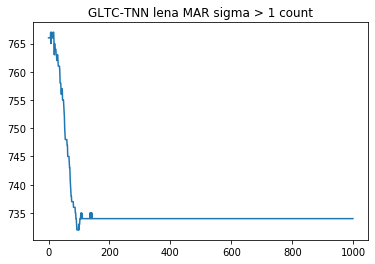

In [58]:
plt.plot(count[0:])
plt.title('GLTC-TNN lena MAR sigma > 1 count')
plt.show()

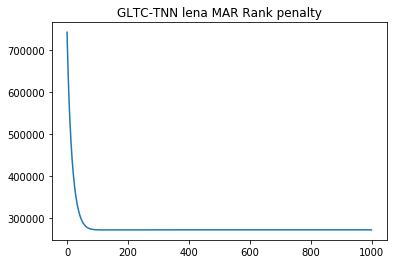

In [59]:
plt.plot(rankp[0:])
plt.title('GLTC-TNN lena MAR Rank penalty')
plt.show()

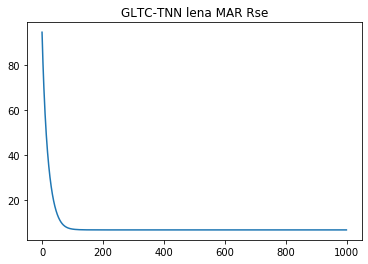

In [60]:
plt.plot(100 * rse[0:])
plt.title('GLTC-TNN lena MAR Rse')
plt.show()

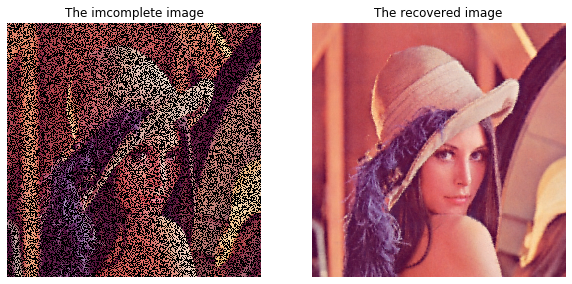

In [61]:
plt.subplots(1, 2, figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rec)
plt.title('The recovered image')
plt.axis('off')
plt.show()

Table 1-1: **Experiment results** (RSE performance) of image inpainting for `lena` and `peppers` using GLTC-TNN:

|  Images   |      MAR      |     R-MAR      |   C-MAR   |     RC-MAR     |
|:----------|--------------:|---------------:|----------:|---------------:|
| **lena**  |     6.72      |       8.25     |   11.02   |      8.53      |
|**peppers**|     7.45      |      11.20     |   12.13   |      9.73      |

- Parameter setting:

 - `alpha` = 30, `beta` = 0.1 * `rho`, `rho` = 1.001, and `theta` = 30.

### Whole Performance

We choose the images of `lena` and `peppers` for evaluation.

#### MAR (Missing at random)

In [11]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
theta = 2
alpha = 1000
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask = np.round(np.random.rand(dim1, dim2) + 0.5 - rate)  # Generate a binary mask.
            sparse_image = image.copy()
            for k in range(dim3):
                sparse_image[:, :, k] = np.multiply(image[:, :, k], mask) # Generate incomplete image
            image_hat = GLTC_Geman(image, sparse_image, alpha, beta, rho, theta, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [12]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[6.0323858  6.89776777 8.12218106]
 [6.50866194 7.68070857 9.30642209]]

[[0.07081231 0.07259716 0.08261263]
 [0.07621743 0.07420882 0.09317491]]


#### R-MAR (Row-wise missing at random)

In [13]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

theta = 2
alpha = 10
rho = 10
beta = 0.1 * rho
maxiter = 1000
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GLTC_TNN(image, sparse_image, alpha, beta, rho, theta, maxiter, validation = 0)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [13]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[ 7.2069242   8.76976792 13.52053155]
 [ 9.24158454 11.41661787 16.55224243]]

[[0.42396426 0.6342408  2.47936587]
 [0.72615422 1.56019054 3.175618  ]]


#### C-MAR (Column-wise missing at random)

In [14]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

theta = 2
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 10
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_column = np.round(np.random.rand(dim2) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim1):
                for j in range(dim3):
                    image0[i, :, j] = np.multiply(image[i, :, j], mask_column)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GLTC_TNN(image, sparse_image, alpha, beta, rho, theta, maxiter, validation = 0)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [15]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[ 8.62918682 10.23776148 15.56852046]
 [ 9.51482769 11.76328923 17.99730053]]

[[0.76602461 0.86580197 3.37489485]
 [0.798651   0.88324591 4.20659913]]


#### RC-MAR ((Row, column)-wise missing at random)

In [16]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

theta = 2
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - (1 - np.sqrt(1 - rate)))
            mask_column = np.round(np.random.rand(dim2) + 0.5 - (1 - np.sqrt(1 - rate)))
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            for i in range(dim1):
                for j in range(dim3):
                    sparse_image[i, :, j] = np.multiply(image0[i, :, j], mask_column)
            image_hat = GLTC_TNN(image, sparse_image, alpha, beta, rho, theta, maxiter, validation = 0)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [17]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[ 7.40833261  8.43859812 10.09082545]
 [ 8.85422039 10.0831485  12.34413855]]

[[0.37855183 0.39207752 0.56838029]
 [0.7159894  0.72571371 0.80202875]]


Table 1-2: **Experiment results** (RSE performance) of image inpainting on two color images using GLTC-TNN:

|    -      | Scenario  |      MAR       |     R-MAR      |      C-MAR     |     RC-MAR     |
|:----------|:----------|---------------:|---------------:|---------------:|---------------:|
|  **Lena** | **30%**   |       ~        |       ~        |        ~       |        ~       |
|       -   | **50%**   |       ~        |       ~        |        ~       |        ~       |
|       -   | **70%**   |       ~        |       ~        |        ~       |        ~       |
|**Peppers**| **30%**   |       ~        |       ~        |        ~       |        ~       |
|       -   | **50%**   |       ~        |       ~        |        ~       |        ~       |
|       -   | **70%**   |       ~        |       ~        |        ~       |        ~       |